# ASSESSMENT OF GOOLE ANALYTICS SESSION QUALITY METRIC

## Import libraries

In [1]:
# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# ML
from src import helpers as h
from src import visuals as v

# Load BQ and credentials
%load_ext google.cloud.bigquery

In [ ]:
!gcloud auth application-default login

In [20]:
# Run to reload external scripts
import importlib
importlib.reload(v)

<module 'src.visuals' from '/Users/gunnar.griese/Desktop/python3_env/ga-session-quality/src/visuals.py'>

## Load data

In [19]:
%%bigquery df

#####################
# Description: Query data necessary to evaluate Session Quality Score
# Reference: https://support.google.com/analytics/answer/3437719?hl=en
#####################

-- Query data with session-scope
WITH session_scope AS(
    SELECT
        fullVisitorId,
        CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)) AS session_id,
        date,
        EXTRACT(
            DAYOFWEEK
            FROM
                TIMESTAMP_SECONDS(visitStartTime)
        ) AS day_of_week,
        EXTRACT(
            HOUR
            FROM
                TIMESTAMP_SECONDS(visitStartTime)
        ) AS hour_of_day,
        IFNULL(totals.pageviews, 0) AS pageviews,
        IFNULL(totals.hits, 0) AS hits,
        channelGrouping AS channel,
        IFNULL(totals.timeOnSite, 0) AS time_on_site,
        IFNULL(totals.totalTransactionRevenue, 0) / 1000000 AS revenue,
        IFNULL(totals.newVisits, 0) AS new_visit,
        IFNULL(totals.bounces, 0) AS bounce,
        device.deviceCategory AS device,
        SAFE_DIVIDE(totals.sessionQualityDim, 100) AS ga_pred,
        IF(totals.transactions > 0, 1, 0) as transaction
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_201707*`
),

-- Query data with hit-scope and aggregate it to session-scope
hit_scope AS(
    SELECT
        CONCAT(fullVisitorId, CAST(visitStartTime AS STRING)) AS session_id_h,
        COUNTIF(hits.eCommerceAction.action_type = "2") AS product_detail_view,
        COUNTIF(hits.eCommerceAction.action_type = "3") AS add_to_cart,
        COUNTIF(hits.eCommerceAction.action_type = "4") AS remove_from_cart,
        COUNTIF(hits.eCommerceAction.action_type = "5") AS checkout,
        COUNTIF(hits.eCommerceAction.action_type = "6") AS purchase
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_201707*` AS GA,
        UNNEST(GA.hits) AS hits
    GROUP BY
        session_id_h
) 

-- Join both datasets
SELECT
    *
EXCEPT(session_id_h)
FROM
    session_scope AS s
    LEFT JOIN hit_scope AS h ON s.session_id = h.session_id_h

In [3]:
# See first few columns
df.head(2)

,fullVisitorId,session_id,date,day_of_week,hour_of_day,pageviews,hits,channel,time_on_site,revenue,new_visit,bounce,device,ga_pred,transaction,product_detail_view,add_to_cart,remove_from_cart,checkout,purchase
0,8886987459700943233,88869874597009432331500412700,20170718,3,21,5,5,Direct,129,0.0,1,0,mobile,0.01,0,0,0,0,0,0
1,1876671342556633024,18766713425566330241500444122,20170718,4,6,9,9,Direct,279,0.0,1,0,mobile,0.01,0,0,0,0,0,0


In [4]:
# Get basic descriptives
df.describe()

,day_of_week,hour_of_day,pageviews,hits,time_on_site,revenue,new_visit,bounce,ga_pred,transaction,product_detail_view,add_to_cart,remove_from_cart,checkout,purchase
count,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000,65823.000000,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000,71812.000000
mean,3.941403,12.373949,3.767532,4.513118,145.820434,2.238343,0.761447,0.506990,0.042557,0.014357,0.397928,0.165153,0.026374,0.105929,0.030092
std,1.936413,6.924096,6.330727,8.813765,397.823220,112.581592,0.426202,0.499955,0.130407,0.118958,1.645290,0.985512,0.319490,0.763247,0.256808
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,13.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,18.000000,4.000000,4.000000,92.000000,0.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,23.000000,186.000000,301.000000,11316.000000,25249.260000,1.000000,1.000000,0.990000,1.000000,96.000000,49.000000,29.000000,30.000000,8.000000


## EDA

In [5]:
# Count sessions and avg. quality score per day
timeline = df.groupby("date").agg({"session_id":"count", "ga_pred":"count"}).reset_index()
timeline.columns = ["date", "sessions", "ga_predictions"]

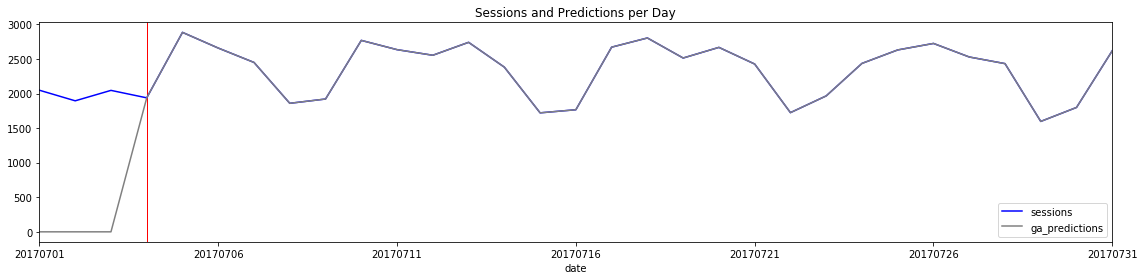

In [6]:
# Plot the timeline
timeline.plot(x="date", 
              y=["sessions", "ga_predictions"], 
              figsize=(16,4), 
              title="Sessions and Predictions per Day",
             color=["blue", "grey"])
plt.axvspan(3, 3, color='red', alpha=1);
plt.tight_layout();
plt.savefig("img/pred_timeline.png")

In [7]:
# Prepare input data for heatmap
heatmap = df[['hour_of_day', 'day_of_week']].reset_index().drop(['index'], axis=1).groupby(['hour_of_day', 'day_of_week'], axis=0).size().unstack()

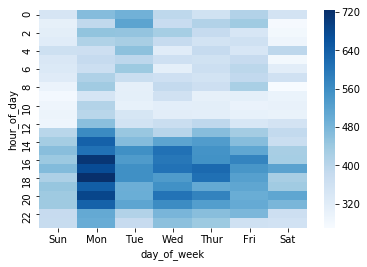

In [8]:
# Plot the amount of sessions per day per hour
sns.heatmap(heatmap, cmap='Blues', xticklabels=['Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat'])
plt.savefig("img/heatmap.png")

## Session Quality Accuracy

In [9]:
# Run in order to reload helper files (directory /src)
import importlib
importlib.reload(v)

<module 'src.visuals' from '/Users/gunnar.griese/Desktop/python3_env/ga-session-quality/src/visuals.py'>

In [10]:
# Assign a class to sessions based on predicted value
df_subset = df[df["ga_pred"]>=0]
df_subset["ga_class_50"] = df_subset["ga_pred"].apply(lambda x: 1 if x >= 0.5 else 0)

/Users/gunnar.griese/Desktop/python3_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# Calculate model performance
df_scores, confusion_matrix, fp_value, tp_value, auc_value = h.get_error_scores(df_subset["transaction"], df_subset["ga_class_50"])

In [12]:
print("Classifier performance is as follows:")
print("------------------------------------------")
print(df_scores)
print("------------------------------------------")

Classifier performance is as follows:
------------------------------------------
   Accuracy       F1    Recall  Precision
0  0.977607  0.51321  0.771599   0.384463
------------------------------------------


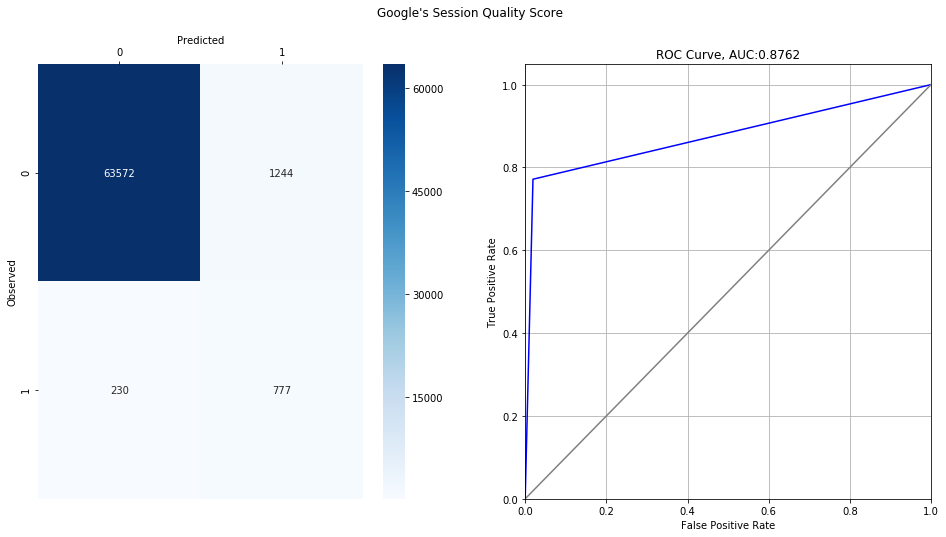

In [21]:
# Visualise model performance
v.plot_errors(confusion_matrix, fp_value, tp_value, auc_value)
plt.savefig("img/confusion_matrix.png")

## Identify drivers of session quality score

In [15]:
# One hot encode categorical data for correlation matrix
corr_df = pd.get_dummies(df_subset, columns=["channel", "device", "hour_of_day", "day_of_week"])

In [16]:
corr_df.columns

Index(['fullVisitorId', 'session_id', 'date', 'pageviews', 'hits',
       'time_on_site', 'revenue', 'new_visit', 'bounce', 'ga_pred',
       'transaction', 'product_detail_view', 'add_to_cart', 'remove_from_cart',
       'checkout', 'purchase', 'ga_class_50', 'channel_(Other)',
       'channel_Affiliates', 'channel_Direct', 'channel_Display',
       'channel_Organic Search', 'channel_Paid Search', 'channel_Referral',
       'channel_Social', 'device_desktop', 'device_mobile', 'device_tablet',
       'hour_of_day_0', 'hour_of_day_1', 'hour_of_day_2', 'hour_of_day_3',
       'hour_of_day_4', 'hour_of_day_5', 'hour_of_day_6', 'hour_of_day_7',
       'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10', 'hour_of_day_11',
       'hour_of_day_12', 'hour_of_day_13', 'hour_of_day_14', 'hour_of_day_15',
       'hour_of_day_16', 'hour_of_day_17', 'hour_of_day_18', 'hour_of_day_19',
       'hour_of_day_20', 'hour_of_day_21', 'hour_of_day_22', 'hour_of_day_23',
       'day_of_week_1', 'day_of_week_

In [17]:
corr_df = corr_df[['ga_pred', 'pageviews', 'time_on_site', 'revenue', 'new_visit',
       'bounce', 'transaction', 'product_detail_view',
       'add_to_cart', 'remove_from_cart', 'checkout', 'purchase',
       'channel_(Other)', 'channel_Affiliates',
       'channel_Direct', 'channel_Display', 'channel_Organic Search',
       'channel_Paid Search', 'channel_Referral', 'channel_Social',
       'device_desktop', 'device_mobile', 'device_tablet']]

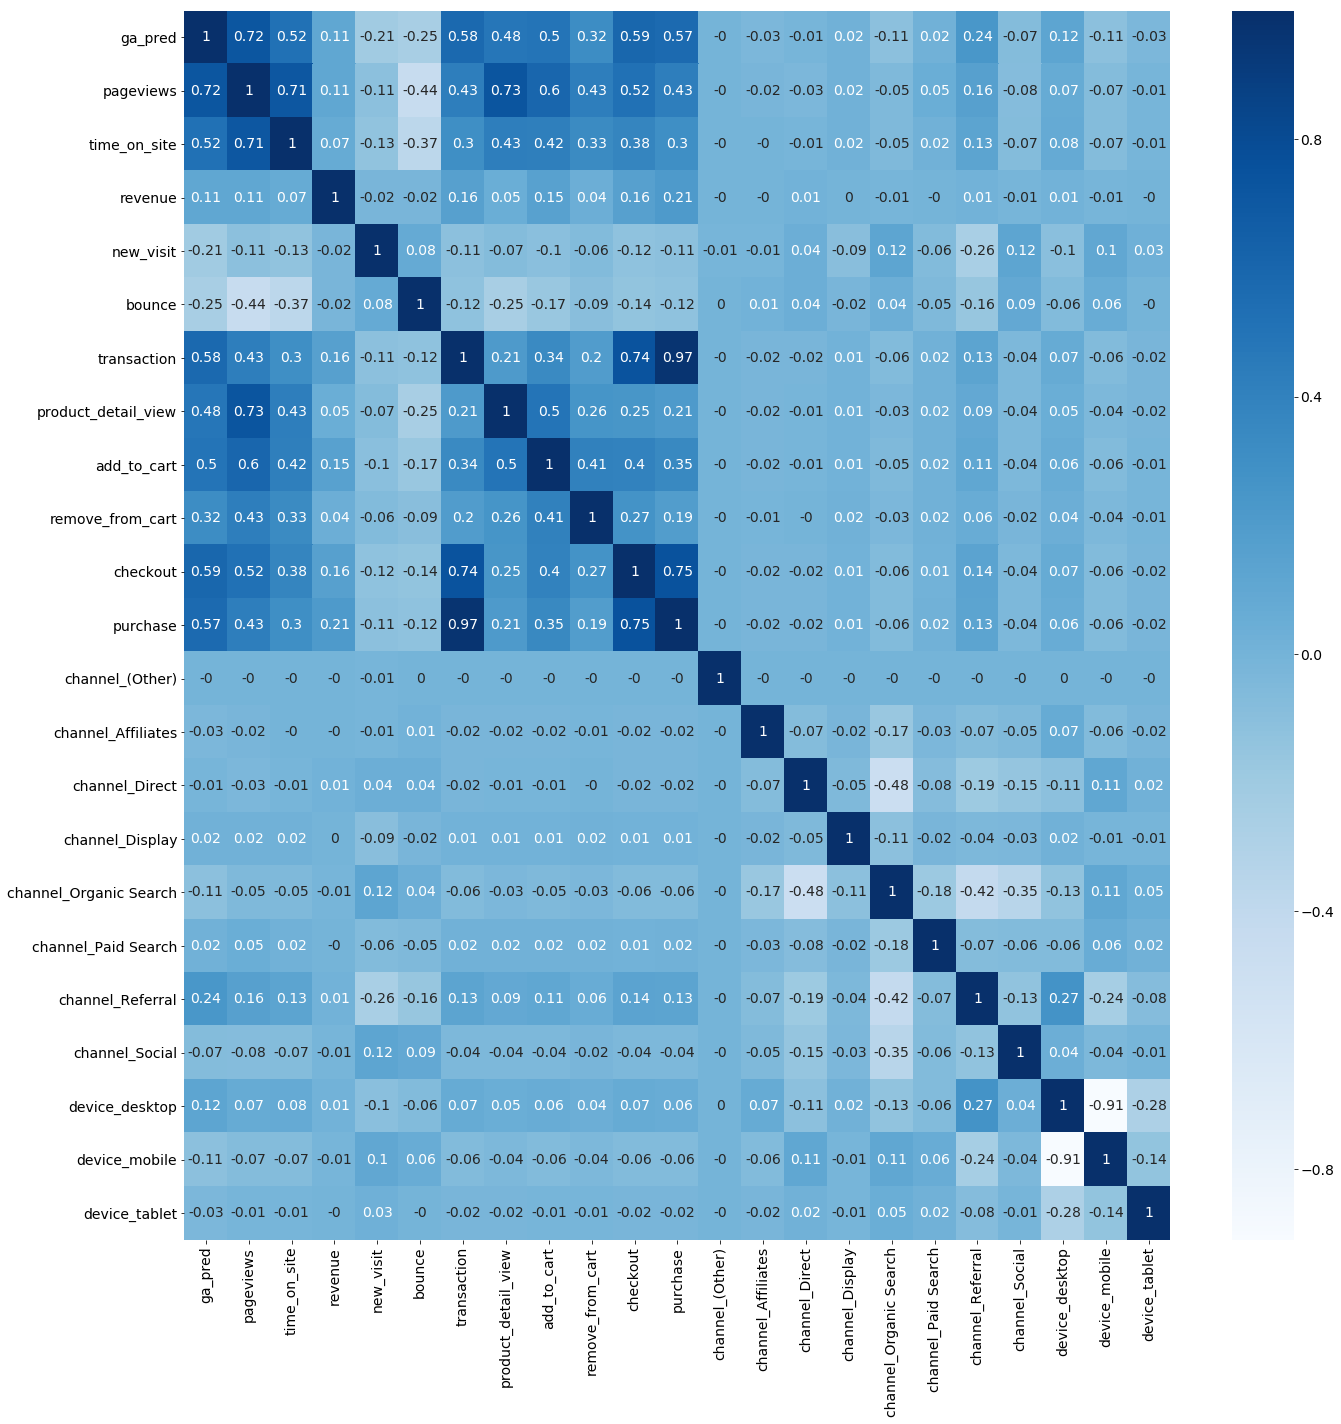

In [26]:
# Plot correlation matrix
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_df.corr().round(2), annot=True, cmap='Blues');
plt.tight_layout()
plt.savefig("img/correlation.png")